In [1]:
import pandas as pd
import os
import pretty_midi
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

# Need to generate the dataset!
We first need to properly label all of our midi files. We'll also reserve a few so we can test our model. 


Read metadata into a pandas dataframe so we can use it for matching (id in metadata matches to the numbers at the beginning of the filename)

In [2]:
musicnet_labels=pd.read_csv('/Users/lhunt/DataChallenges/Musicnet_Classification/archive/musicnet_metadata.csv')

Label all of the midi files with Composer, song name

In [3]:
musicnet_labels.set_index('id',inplace=True)

In [4]:
midi_files=[]
for path,dr,fils in os.walk('archive/musicnet_midis/musicnet_midis'):
    if fils:
        for fil in fils:
            if fil.endswith('.mid'):
                midi_files.append(os.path.join(path,fil))

Make labelled midi directory and unlabelled midi directory. 

In [5]:
if not os.path.exists('labelled_midis'):
    os.mkdir('labelled_midis')
if not os.path.exists('unlabelled_midis'):
    os.mkdir('unlabelled_midis')
for i,fl in enumerate(midi_files):
    if i%8!=0:
        composer=fl.split('/')[-2]
        if not os.path.exists(os.path.join('labelled_midis',composer)):
            os.mkdir(os.path.join('labelled_midis',composer))
        index=int(fl.split('/')[-1].split('_')[0])
        song_string=re.sub(r"[^a-zA-Z0-9]+", '_', musicnet_labels.loc[index].composition)
        new_filename_string=musicnet_labels.loc[index].composer+'_'+song_string+'.mid'
        os.rename(fl,os.path.join('labelled_midis',composer,new_filename_string))
    else:
        os.rename(fl,os.path.join('unlabelled_midis',fl.split('/')[-1]))



In [6]:
labelled_midis=[]
for root,drs,fils in os.walk('.'):
    if fils:
        for fil in fils:
            if (fil.endswith('.mid')) & ('unlabelled' not in root) & ('chunks' not in root):
                labelled_midis.append(os.path.join(root,fil))

### Need to generate the dataset!
We have midi files, but we need to extract some information from them that will help us determine which composer wrote each song!
 * To do this we'll use pretty midi
 * Start by making a dictionary for each of the information we want to extract
    * Need to make sure all values are divided by song length (Longer songs can have a higher median tempo change time for example) 
 * Will move to pandas dictionary


In [7]:
midi_info_dict={}
midi_info_dict['Composer']=np.array([])
midi_info_dict['n_temp_change']=np.array([])
midi_info_dict['median_tempo_change_time']=np.array([])
midi_info_dict['estimated_tempo']=np.array([])
midi_info_dict['beat_start']=np.array([])
midi_info_dict['n_beats']=np.array([])
midi_info_dict['median_beat_time']=np.array([])
midi_info_dict['n_downbeats']=np.array([])
midi_info_dict['median_downbeat_time']=np.array([])
midi_info_dict['average_chroma']=np.array([])
for i,fl in enumerate(labelled_midis):
    composer=fl.split('/')[-1].split('_')[0]
    try:
        mdi=pretty_midi.PrettyMIDI(fl)
    except:
        print('Problem reading midi file {}'.format(fl))
        continue
    midi_info_dict['Composer']=np.append(midi_info_dict['Composer'],composer)
    midi_info_dict['n_temp_change']=np.append(midi_info_dict['n_temp_change'],len(mdi.get_tempo_changes()[0])/mdi.get_end_time())
    midi_info_dict['median_tempo_change_time']=np.append(midi_info_dict['median_tempo_change_time'],np.median(mdi.get_tempo_changes()[0])/mdi.get_end_time())
    midi_info_dict['estimated_tempo']=np.append(midi_info_dict['estimated_tempo'],mdi.estimate_tempo())
    midi_info_dict['beat_start']=np.append(midi_info_dict['beat_start'],mdi.get_beats()[0])
    midi_info_dict['n_beats']=np.append(midi_info_dict['n_beats'],len(mdi.get_beats())/mdi.get_end_time())
    midi_info_dict['median_beat_time']=np.append(midi_info_dict['median_beat_time'],np.median(mdi.get_beats())/mdi.get_end_time())
    midi_info_dict['n_downbeats']=np.append(midi_info_dict['n_downbeats'],len(mdi.get_downbeats())/mdi.get_end_time())
    midi_info_dict['median_downbeat_time']=np.append(midi_info_dict['median_downbeat_time'],np.median(mdi.get_downbeats())/mdi.get_end_time())
    midi_info_dict['average_chroma']=np.append(midi_info_dict['average_chroma'],np.mean(mdi.get_chroma()))


/opt/homebrew/Caskroom/miniforge/base/envs/sklearn/lib/python3.8/site-packages/pretty_midi/pretty_midi.py:97: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Problem reading midi file ./labelled_midis/Bach/Bach_WTK_I_No_14_Prelude_and_Fugue_in_F_sharp_minor.mid
Problem reading midi file ./labelled_midis/Bach/Bach_WTK_I_No_19_Prelude_and_Fugue_in_A_major.mid
Problem reading midi file ./labelled_midis/Bach/Bach_WTK_I_No_15_Prelude_and_Fugue_in_G_major.mid
Problem reading midi file ./labelled_midis/Bach/Bach_WTK_I_No_6_Prelude_and_Fugue_in_D_minor.mid
Problem reading midi file ./labelled_midis/Bach/Bach_WTK_I_No_13_Prelude_and_Fugue_in_F_sharp_major.mid


In [8]:
midi_info_df=pd.DataFrame(midi_info_dict)

In [9]:
midi_info_df.describe()

,n_temp_change,median_tempo_change_time,estimated_tempo,beat_start,n_beats,median_beat_time,n_downbeats,median_downbeat_time,average_chroma
count,116.000000,116.000000,116.000000,116.0,116.000000,116.000000,116.000000,116.000000,116.000000
mean,0.412955,0.557417,200.799893,0.0,1.818615,0.500004,0.639089,0.498803,20.788163
std,1.339395,0.291796,35.570117,0.0,0.992445,0.026411,0.358034,0.027257,7.513037
min,0.002303,0.000000,128.445878,0.0,0.342900,0.452791,0.130595,0.465021,7.694533
25%,0.056395,0.455280,169.886841,0.0,1.105872,0.490529,0.320079,0.489824,16.711515
50%,0.127708,0.567318,198.380817,0.0,1.614167,0.495995,0.568622,0.494793,19.709835
75%,0.241314,0.715099,228.098601,0.0,2.337408,0.499346,0.875581,0.498697,24.495070
max,11.151532,0.987002,284.644748,0.0,5.043279,0.675082,1.682165,0.657537,57.458426


Beat start is all zeros. Let's drop that column since it has no useful information

In [10]:
midi_info_df.drop('beat_start',axis=1,inplace=True)

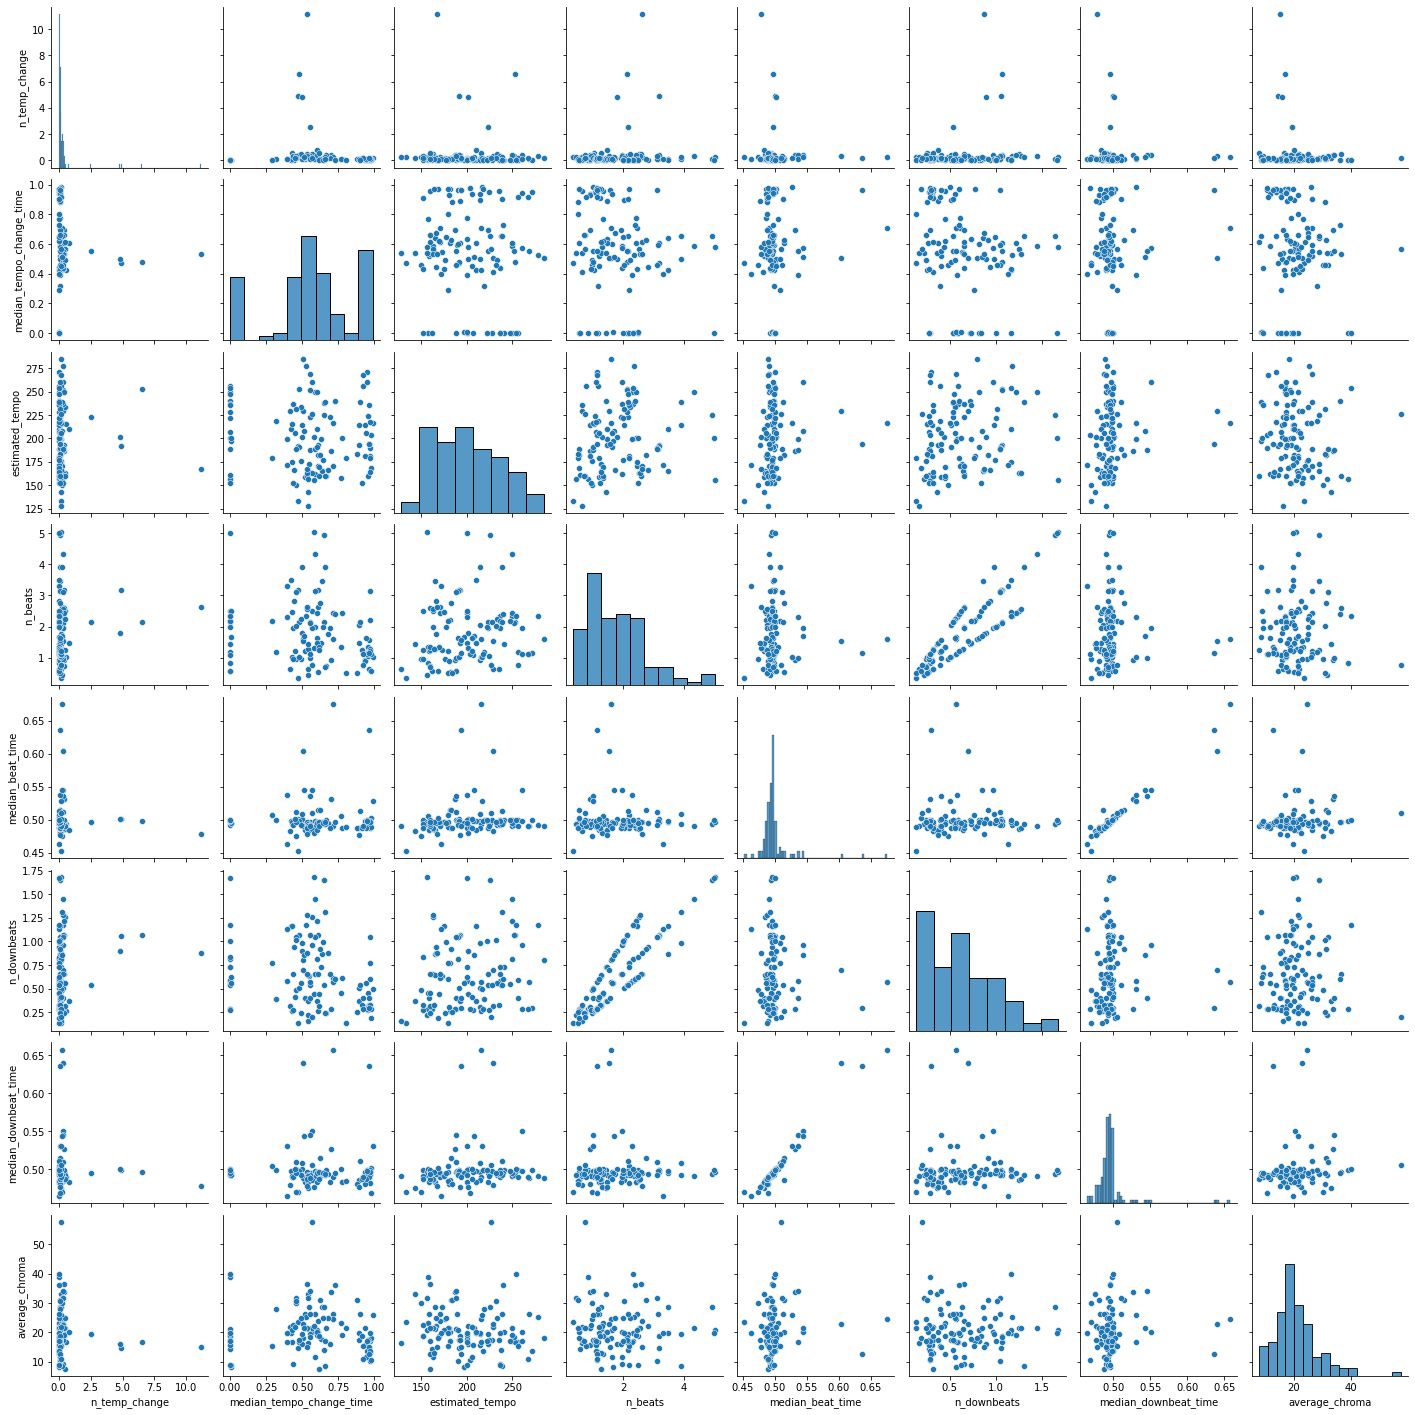

In [11]:
sns.pairplot(midi_info_df)


Somewhat expectedly, information from beats and downbeats seem to be repeated (median_beat_time vs median_downbeat_time is linear)
Remove information on median downbeat. Let's start with KNN algorithm. 

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import seaborn as sns

Turn the composer names into numerical values. We'll keep the real values so we can match them. 

In [13]:
midi_info_df['Composer_ints']=pd.factorize(midi_info_df['Composer'])[0]+1

make dataset, then scale it

In [14]:
X=StandardScaler().fit_transform(midi_info_df[['n_temp_change',
                                             'median_tempo_change_time',
                                             'estimated_tempo',
                                             'n_beats',
                                             'median_beat_time',
                                             'n_downbeats',
                                             'median_downbeat_time',
                                             'average_chroma']])

In [15]:
X_train,X_test,y_train,y_test=train_test_split(X,midi_info_df['Composer_ints'].values,test_size=0.3)

In [16]:
KNN_Classifier=KNeighborsClassifier(n_neighbors=5)

In [17]:
KNN_Classifier.fit(X_train,y_train)

KNeighborsClassifier()

In [18]:
y_pred=KNN_Classifier.predict(X_test)

In [19]:
print('Accuracy Score = {}'.format(accuracy_score(y_test,y_pred)))

Accuracy Score = 0.6


Accuracy is only 50%. Could be too many variables. Try Principal Component Analysis

In [20]:
from sklearn.decomposition import PCA

In [21]:
for j in range(12):
    for i in range(8):
        reduced_data=PCA(n_components=5).fit_transform(X)
        X_train_reduced,X_test_reduced,y_train_reduced,y_test_reduced=train_test_split(reduced_data,midi_info_df.Composer_ints)
        KNN_Classifier.fit(X_train_reduced,y_train_reduced)
        y_pred_reduced=KNN_Classifier.predict(X_test_reduced)
        print('Accuracy Score is {} for {} components'.format(accuracy_score(y_test_reduced,y_pred_reduced),i))

Accuracy Score is 0.5517241379310345 for 0 components
Accuracy Score is 0.6896551724137931 for 1 components
Accuracy Score is 0.5517241379310345 for 2 components
Accuracy Score is 0.5862068965517241 for 3 components
Accuracy Score is 0.6551724137931034 for 4 components
Accuracy Score is 0.5862068965517241 for 5 components
Accuracy Score is 0.6896551724137931 for 6 components
Accuracy Score is 0.5517241379310345 for 7 components
Accuracy Score is 0.5862068965517241 for 0 components
Accuracy Score is 0.5862068965517241 for 1 components
Accuracy Score is 0.6896551724137931 for 2 components
Accuracy Score is 0.7241379310344828 for 3 components
Accuracy Score is 0.5862068965517241 for 4 components
Accuracy Score is 0.7586206896551724 for 5 components
Accuracy Score is 0.5517241379310345 for 6 components
Accuracy Score is 0.6206896551724138 for 7 components
Accuracy Score is 0.3793103448275862 for 0 components
Accuracy Score is 0.6206896551724138 for 1 components
Accuracy Score is 0.55172413

Clearly we don't have enough songs for the 10 composers, because the accuracy is highly dependent on the way the training data is split. Perhaps we can get more data by breaking the songs up into smaller chunks? We can create a bunch of midi files by selecting a random 30 second chunk from each song, create a new midi file, and extract information from it. 

Let's try to make 10 new midi files per original song. Since midi is all text, a 30 second file should be small. We'll keep the composer name in the song title. We'll make the start times random (but less than 30 seconds before the end of the song)

In [22]:
if not os.path.exists('labelled_midi_chunks'):
    os.mkdir('labelled_midi_chunks')

In [23]:
np.random.seed(12)

In [24]:
for song in labelled_midis:
    for i,start_time_percent in enumerate(np.random.random(10)):
        try:
            mdi_fl = pretty_midi.PrettyMIDI(song)
        except:
            print('{} could not be read! Moving on to the next song'.format(song))
            continue
        last_possible_time_to_split=mdi_fl.get_end_time() - 30.0
        start_time=last_possible_time_to_split * start_time_percent
        mdi_fl.adjust_times([start_time,start_time+30],[0,30])
        new_midi_title=song.split('/')[-1].split('.mid')[0]+'_{}.mid'.format(i)
        mdi_fl.write(os.path.join('labelled_midi_chunks',new_midi_title))

/opt/homebrew/Caskroom/miniforge/base/envs/sklearn/lib/python3.8/site-packages/pretty_midi/pretty_midi.py:97: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


./labelled_midis/Bach/Bach_WTK_I_No_14_Prelude_and_Fugue_in_F_sharp_minor.mid could not be read! Moving on to the next song
./labelled_midis/Bach/Bach_WTK_I_No_14_Prelude_and_Fugue_in_F_sharp_minor.mid could not be read! Moving on to the next song
./labelled_midis/Bach/Bach_WTK_I_No_14_Prelude_and_Fugue_in_F_sharp_minor.mid could not be read! Moving on to the next song
./labelled_midis/Bach/Bach_WTK_I_No_14_Prelude_and_Fugue_in_F_sharp_minor.mid could not be read! Moving on to the next song
./labelled_midis/Bach/Bach_WTK_I_No_14_Prelude_and_Fugue_in_F_sharp_minor.mid could not be read! Moving on to the next song
./labelled_midis/Bach/Bach_WTK_I_No_14_Prelude_and_Fugue_in_F_sharp_minor.mid could not be read! Moving on to the next song
./labelled_midis/Bach/Bach_WTK_I_No_14_Prelude_and_Fugue_in_F_sharp_minor.mid could not be read! Moving on to the next song
./labelled_midis/Bach/Bach_WTK_I_No_14_Prelude_and_Fugue_in_F_sharp_minor.mid could not be read! Moving on to the next song
./labell

Now lets try to extract some of the information we extracted above. We won't have to normalize by song length now, since that is now normalized

In [25]:
labelled_midi_chunks=[]
for fl in os.listdir('labelled_midi_chunks'):
    labelled_midi_chunks.append(os.path.join('labelled_midi_chunks',fl))

In [26]:
midi_info_dict={}
midi_info_dict['Composer']=np.array([])
midi_info_dict['n_temp_change']=np.array([])
midi_info_dict['estimated_tempo']=np.array([])
midi_info_dict['n_beats']=np.array([])
midi_info_dict['average_chroma']=np.array([])
for i,fl in enumerate(labelled_midi_chunks):
    composer=fl.split('/')[-1].split('_')[0]
    try:
        mdi=pretty_midi.PrettyMIDI(fl)
    except:
        print('Problem reading midi file {}'.format(fl))
        continue
    midi_info_dict['Composer']=np.append(midi_info_dict['Composer'],composer)
    midi_info_dict['n_temp_change']=np.append(midi_info_dict['n_temp_change'],len(mdi.get_tempo_changes()[0]))
    midi_info_dict['estimated_tempo']=np.append(midi_info_dict['estimated_tempo'],mdi.estimate_tempo())
    midi_info_dict['n_beats']=np.append(midi_info_dict['n_beats'],len(mdi.get_beats()))
    midi_info_dict['average_chroma']=np.append(midi_info_dict['average_chroma'],np.mean(mdi.get_chroma()))


In [27]:
midi_info_df=pd.DataFrame(midi_info_dict)

In [28]:
midi_info_df

,Composer,n_temp_change,estimated_tempo,n_beats,average_chroma
0,Bach,1.0,200.000000,51.0,10.799827
1,Bach,1.0,273.200095,35.0,7.965322
2,Beethoven,1.0,157.710922,42.0,16.215666
3,Mozart,1.0,264.615649,37.0,15.625097
4,Bach,1.0,273.200095,35.0,13.012855
...,...,...,...,...,...
1565,Beethoven,15.0,240.865957,32.0,14.502602
1566,Bach,1.0,233.846505,21.0,17.781540
1567,Beethoven,21.0,162.377654,77.0,19.066974
1568,Bach,4.0,273.208492,35.0,11.477247


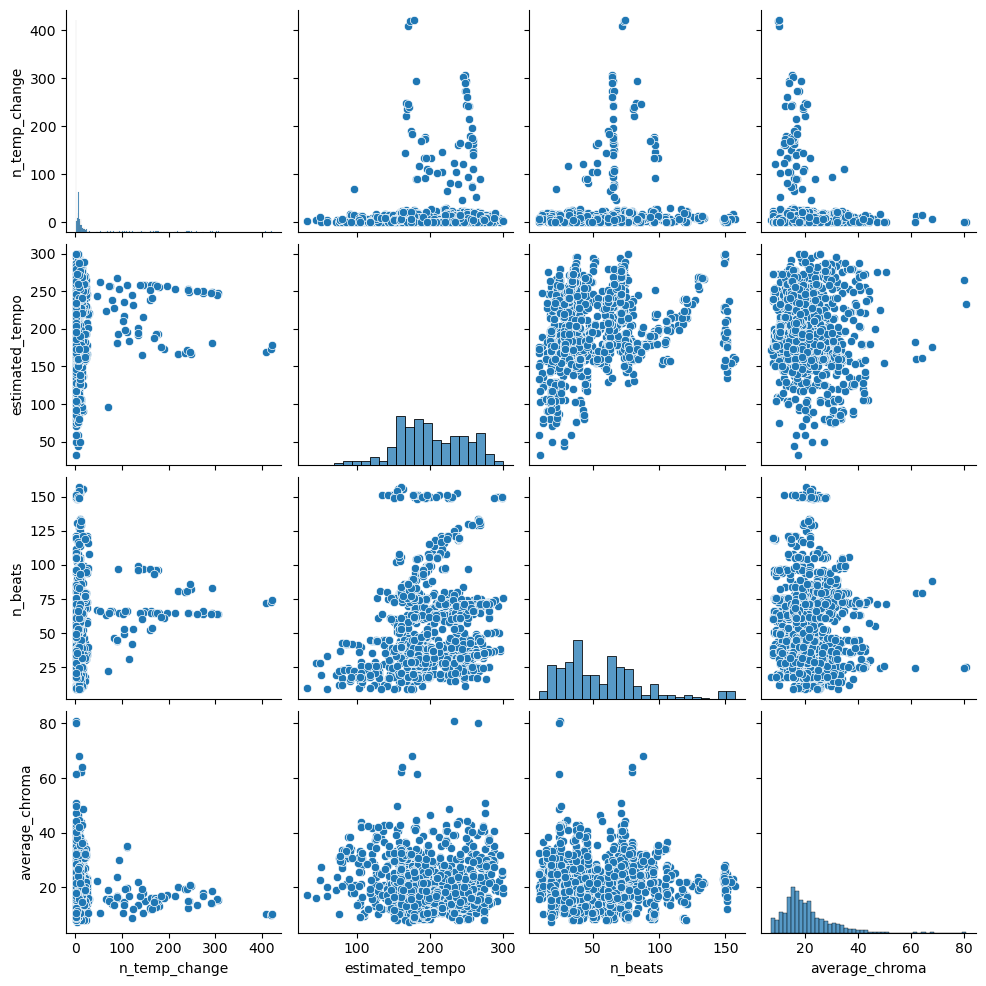

In [29]:
sns.pairplot(midi_info_df)

In [30]:
midi_info_df['Composer_ints']=pd.factorize(midi_info_df['Composer'])[0]+1

make dataset, then scale it

In [31]:
X=StandardScaler().fit_transform(midi_info_df[['n_temp_change',
                                             'estimated_tempo',
                                             'n_beats',
                                             'average_chroma']])

In [32]:
X_train,X_test,y_train,y_test=train_test_split(X,midi_info_df['Composer_ints'].values,test_size=0.3)

In [33]:
KNN_Classifier=KNeighborsClassifier(n_neighbors=5)

In [34]:
KNN_Classifier.fit(X_train,y_train)

KNeighborsClassifier()

In [35]:
for j in range(12):
    for i in range(8):
        X_train,X_test,y_train,y_test=train_test_split(X,midi_info_df['Composer_ints'].values,test_size=0.3)
        KNN_Classifier.fit(X_train,y_train)
        y_pred=KNN_Classifier.predict(X_test)
        print('Accuracy Score is {}, i={},j={}'.format(accuracy_score(y_test,y_pred),i,j))

Accuracy Score is 0.7303609341825902, i=0,j=0
Accuracy Score is 0.7409766454352441, i=1,j=0
Accuracy Score is 0.7494692144373672, i=2,j=0
Accuracy Score is 0.7367303609341825, i=3,j=0
Accuracy Score is 0.7515923566878981, i=4,j=0
Accuracy Score is 0.732484076433121, i=5,j=0
Accuracy Score is 0.7537154989384289, i=6,j=0
Accuracy Score is 0.7473460721868365, i=7,j=0
Accuracy Score is 0.7813163481953291, i=0,j=1
Accuracy Score is 0.7643312101910829, i=1,j=1
Accuracy Score is 0.7006369426751592, i=2,j=1
Accuracy Score is 0.7346072186836518, i=3,j=1
Accuracy Score is 0.7409766454352441, i=4,j=1
Accuracy Score is 0.7473460721868365, i=5,j=1
Accuracy Score is 0.7430997876857749, i=6,j=1
Accuracy Score is 0.7367303609341825, i=7,j=1
Accuracy Score is 0.7430997876857749, i=0,j=2
Accuracy Score is 0.7303609341825902, i=1,j=2
Accuracy Score is 0.7473460721868365, i=2,j=2
Accuracy Score is 0.7388535031847133, i=3,j=2
Accuracy Score is 0.7473460721868365, i=4,j=2
Accuracy Score is 0.747346072186836

Seems we're getting an accuracy of ~0.75...That seems pretty good! Can we improve this?